In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from huggingface_hub import login
from google.colab import userdata
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from typing import Optional
from transformers import AutoTokenizer
import re
from datetime import datetime
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from collections import Counter, defaultdict
import random
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import json

In [ ]:
hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [ ]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split="full", trust_remote_code=True)

README.md:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

meta_Appliances.jsonl:   0%|          | 0.00/285M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

In [ ]:
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
MIN_TOKENS = 150
MAX_TOKENS = 160
MIN_CHARS = 300
CEILING_CHARS = MAX_TOKENS * 7

class Item:

    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
    PREFIX = "Price is $"
    QUESTION = "How much does this cost to the nearest dollar?"
    REMOVALS = ['"Batteries Included?": "No"', '"Batteries Included?": "Yes"', '"Batteries Required?": "No"', '"Batteries Required?": "Yes"', "By Manufacturer", "Item", "Date First", "Package", ":", "Number of", "Best Sellers", "Number", "Product "]

    title: str
    price: float
    category: str
    token_count: int = 0
    details: Optional[str]
    prompt: Optional[str] = None
    include = False

    def __init__(self, data, price):
        self.title = data['title']
        self.price = price
        self.parse(data)

    def scrub_details(self):

        details = self.details
        for remove in self.REMOVALS:
            details = details.replace(remove, "")
        return details

    def scrub(self, stuff):

        stuff = re.sub(r'[:\[\]"{}【】\s]+', ' ', stuff).strip()
        stuff = stuff.replace(" ,", ",").replace(",,,",",").replace(",,",",")
        words = stuff.split(' ')
        select = [word for word in words if len(word)<7 or not any(char.isdigit() for char in word)]
        return " ".join(select)

    def parse(self, data):

        contents = '\n'.join(data['description'])
        if contents:
            contents += '\n'
        features = '\n'.join(data['features'])
        if features:
            contents += features + '\n'
        self.details = data['details']
        if self.details:
            contents += self.scrub_details() + '\n'
        if len(contents) > MIN_CHARS:
            contents = contents[:CEILING_CHARS]
            text = f"{self.scrub(self.title)}\n{self.scrub(contents)}"
            tokens = self.tokenizer.encode(text, add_special_tokens=False)
            if len(tokens) > MIN_TOKENS:
                tokens = tokens[:MAX_TOKENS]
                text = self.tokenizer.decode(tokens)
                self.make_prompt(text)
                self.include = True

    def make_prompt(self, text):

        self.prompt = f"{self.QUESTION}\n\n{text}\n\n"
        self.prompt += f"{self.PREFIX}{str(round(self.price))}.00"
        self.token_count = len(self.tokenizer.encode(self.prompt, add_special_tokens=False))

    def test_prompt(self):

        return self.prompt.split(self.PREFIX)[0] + self.PREFIX

    def __repr__(self):

        return f"<{self.title} = ${self.price}>"

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

In [ ]:
CHUNK_SIZE = 1000
MIN_PRICE = 0.5
MAX_PRICE = 999.49

class ItemLoader:


    def __init__(self, name):
        self.name = name
        self.dataset = None

    def from_datapoint(self, datapoint):

        try:
            price_str = datapoint['price']
            if price_str:
                price = float(price_str)
                if MIN_PRICE <= price <= MAX_PRICE:
                    item = Item(datapoint, price)
                    return item if item.include else None
        except ValueError:
            return None

    def from_chunk(self, chunk):

        batch = []
        for datapoint in chunk:
            result = self.from_datapoint(datapoint)
            if result:
                batch.append(result)
        return batch

    def chunk_generator(self):

        size = len(self.dataset)
        for i in range(0, size, CHUNK_SIZE):
            yield self.dataset.select(range(i, min(i + CHUNK_SIZE, size)))

    def load_in_parallel(self, workers):

        results = []
        chunk_count = (len(self.dataset) // CHUNK_SIZE) + 1
        with ProcessPoolExecutor(max_workers=workers) as pool:
            for batch in tqdm(pool.map(self.from_chunk, self.chunk_generator()), total=chunk_count):
                results.extend(batch)
        for result in results:
            result.category = self.name
        return results

    def load(self, workers=8):

        start = datetime.now()
        print(f"Loading dataset {self.name}", flush=True)
        self.dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_{self.name}", split="full", trust_remote_code=True)
        results = self.load_in_parallel(workers)
        finish = datetime.now()
        print(f"Completed {self.name} with {len(results):,} datapoints in {(finish-start).total_seconds()/60:.1f} mins", flush=True)
        return results

In [ ]:
dataset_names = [
     "Automotive"
]

In [ ]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

Loading dataset Automotive


meta_Automotive.jsonl:   0%|          | 0.00/5.35G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|██████████| 2004/2004 [1:22:07<00:00,  2.46s/it]


Completed Automotive with 911,688 datapoints in 98.5 mins


In [ ]:
print(f"A grand total of {len(items):,}  Automotive items")

A grand total of 911,688  Automotive items


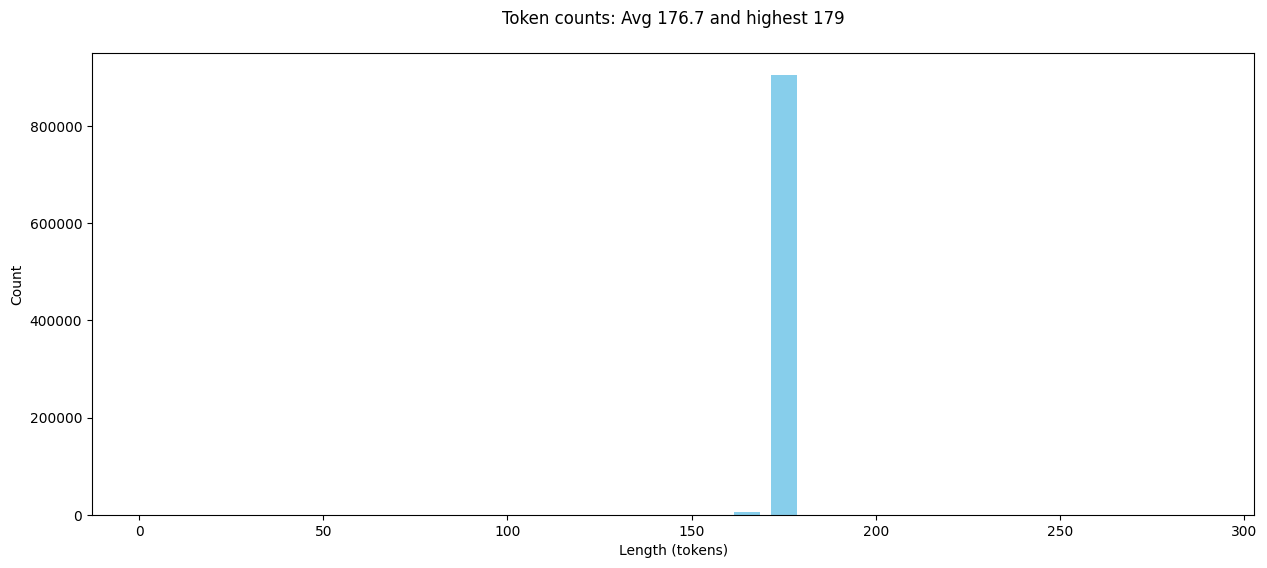

In [ ]:
tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

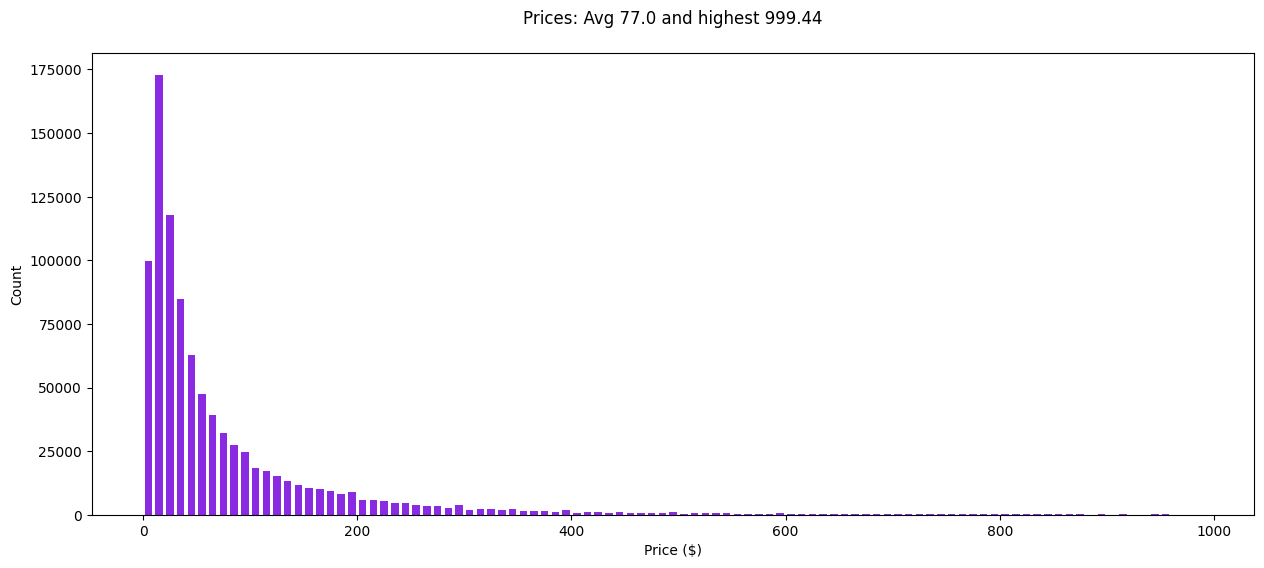

In [ ]:
prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

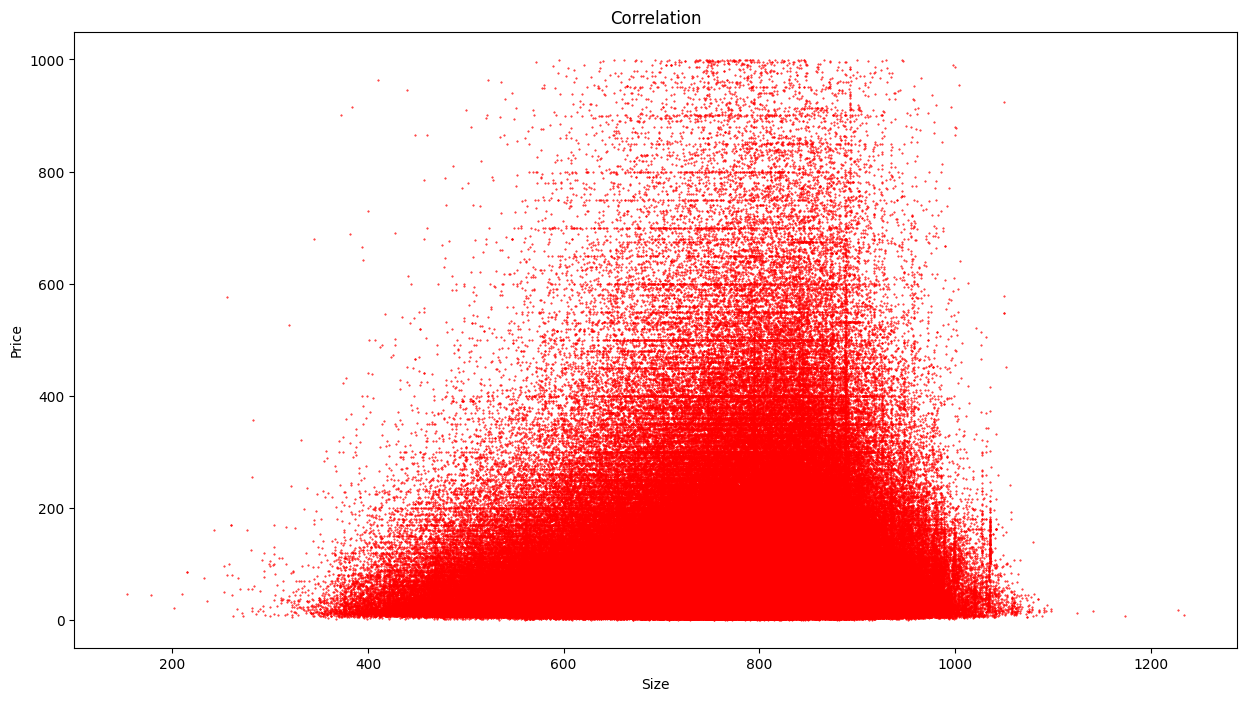

In [ ]:
sample = items

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Correlation')

plt.show()

In [ ]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [ ]:
report(sample[50])

How much does this cost to the nearest dollar?

Lower Undercar Engine Shield Cover - Compatible with Ford Fusion 1.5L 1.6L 2.0L 2.5L FWD
Lower Undercar Engine Shield Cover - Compatible with 2013 - 2020 Ford Fusion 1.5L 1.6L 2.0L 2.5L FWDNote UNDERCAR SHIELD; FITS AND 2.0L FWD ENGINES; MADE AT HERMOSILLA PLANTQuality Capa Certified - Ensures the part fits, performs, and lasts the same as the original.Compatible With or Fits - 2013 - 2020 Ford Fusion - 2013 - 2020 Ford Fusion Energi - 2013 - 2020 Ford Fusion

Price is $165.00
[15, 14337, 43337, 271, 7117, 374, 400, 10680, 13, 410]
['0', ' Ford', ' Fusion', '\n\n', 'Price', ' is', ' $', '165', '.', '00']


In [ ]:
random.seed(42)
random.shuffle(sample)
train = sample[:50_000]
test = sample[50_000:52_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 25,000 items and test set of 2,000 items


In [ ]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Wagner Brake Disc Brake Rotor
Wagner® premium brake rotors are engineered with technology focused on providing maximum performance, corrosion resistance and ease of installation. Pair Wagner rotors with Wagner brake pads for optimal performance. ENGINEERED FOR PERFORMANCE -- OE-specific vane design provides effective braking power and heat dissipation while controlling noise, vibration and harshness PREMIUM PROTECTION -- E-Shield protective coating is applied to non-braking surfaces to inhibit corrosion TURNED AND SMOOTH FINISH -- Requires less pad break-in time and aids in proper bedding EASY INSTALLATION -- Rotors are packaged in a Vapor Corrosion Inhibitor bag, eliminating the need for an oil coating which reduces prep time PROPER BALANCE -- Spin balanced and cut to limit vibration for improving stability and control PERF

Price is $65.00


In [ ]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Lund Catch-It Vinyl Black Rear Seat Floor Mat
Product Features Stylish, premium floor protection Stylish, premium floor protection Custom-molded to your vehicle for full coverage and a perfect fit Custom-molded to your vehicle for full coverage and a perfect fit Durable construction for a lasting, lifetime performance Durable construction for a lasting, lifetime performance Contains spills, mud and moisture to reduce mess on your original carpet Contains spills, mud and moisture to reduce mess on your original carpet Clean easily – simply rinse with garden hose Clean easily – simply rinse with garden hose Tough material withstands mud, snow, rain and chemicals Tough material withstands mud, snow, rain and chemicals Stain and heat resistant Stain and heat resistant Heavy-duty, durable material and raised ridges scrapes debris from shoes

Price is $


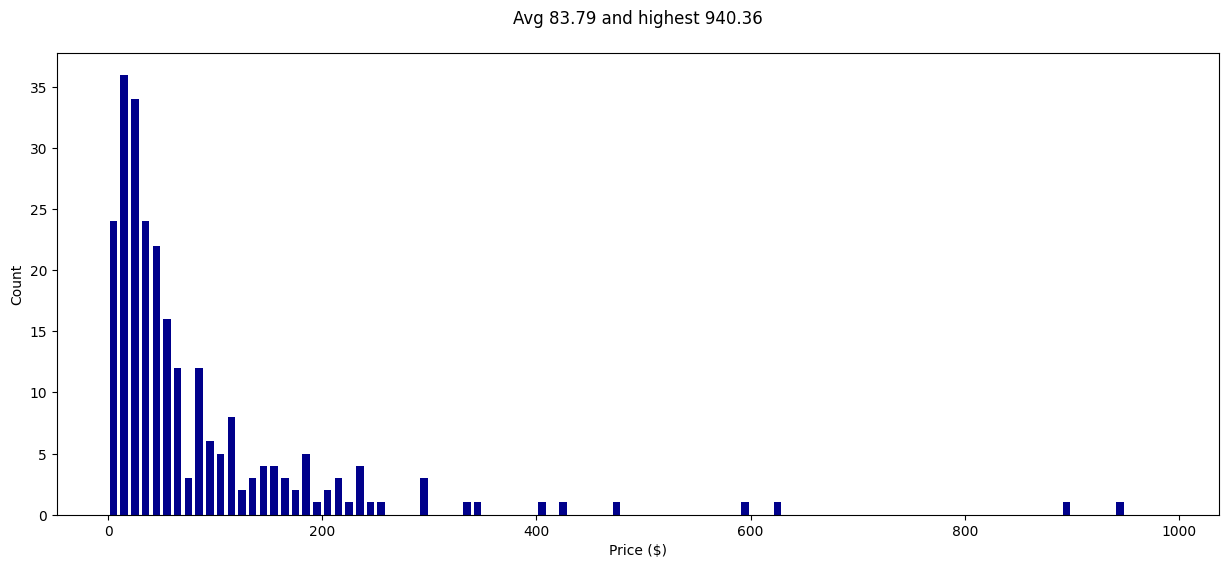

In [ ]:
prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

In [ ]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [ ]:
train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset.save_to_disk('/content/drive/My Drive/my_dataset_mini')

Mounted at /content/drive


Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
with open('train_mini.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test_mini.pkl', 'wb') as file:
    pickle.dump(test, file)